# Modelo de Inferencia Solo Texto (TF-IDF)
Entrena un modelo que recibe **solo la descripción** y predice viabilidad con justificación básica.

**Entrada:** `data/processed/startups_sintetico_1000_processed.csv` (usa columnas `descripcion` y `viabilidad`).

In [2]:

# Imports
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
RANDOM_STATE = 42
np.random.seed(42)

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (roc_auc_score, f1_score, precision_score, recall_score,
                             accuracy_score, confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay)

from joblib import dump

def find_project_root(start: Path = None) -> Path:
    p = start or Path.cwd()
    for cand in [p, *p.parents]:
        if (cand / "data" / "raw").exists():
            return cand
    raise FileNotFoundError("No se encontró la carpeta 'data/raw' en la jerarquía del proyecto.")

PROJECT_ROOT = find_project_root()
processed_path = PROJECT_ROOT / "data" / "processed" / "startups_sintetico_1000_processed.csv"
assert processed_path.exists(), "Ejecuta el notebook de exploración para generar el procesado primero."
df = pd.read_csv(processed_path, encoding="utf-8")
df = df[["descripcion","viabilidad"]].dropna()
df["descripcion"] = df["descripcion"].astype(str)
print(df.shape)
df.head(3)


(992, 2)


,descripcion,viabilidad
0,equipo con 8+ años de experiencia. operando en...,1
1,operando en el mercado,1
2,buena presencia en redes. operando en el merca...,1


## Split y pipeline TF-IDF + LogReg

AUC: 0.5706914344685242
F1: 0.689922480620155 Prec: 0.6180555555555556 Rec: 0.7807017543859649 Acc: 0.5979899497487438
Matriz de confusión
 [[30 55]
 [25 89]]


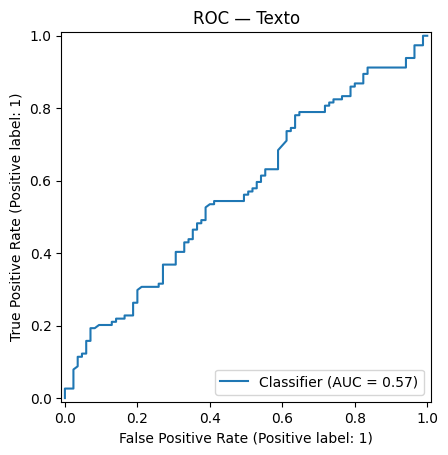

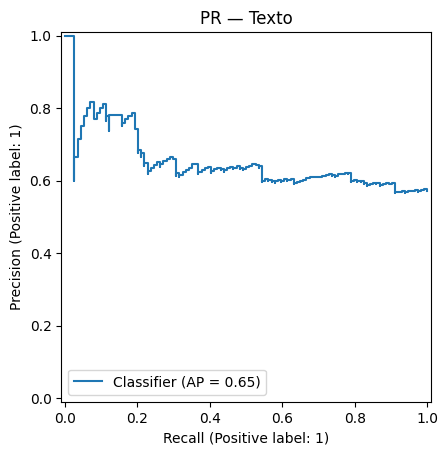

In [3]:

X_train, X_test, y_train, y_test = train_test_split(df["descripcion"], df["viabilidad"].astype(int),
                                                    test_size=0.2, stratify=df["viabilidad"].astype(int),
                                                    random_state=RANDOM_STATE)

pipe = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=800, ngram_range=(1,2), min_df=2)),
    ("clf", LogisticRegression(max_iter=400, random_state=RANDOM_STATE))
])
pipe.fit(X_train, y_train)

# Evaluación
scores = pipe.predict_proba(X_test)[:,1]
yhat = (scores>=0.5).astype(int)
print("AUC:", roc_auc_score(y_test, scores))
print("F1:", f1_score(y_test, yhat), "Prec:", precision_score(y_test, yhat), "Rec:", recall_score(y_test, yhat), "Acc:", accuracy_score(y_test, yhat))
print("Matriz de confusión\n", confusion_matrix(y_test, yhat))

_ = RocCurveDisplay.from_predictions(y_test, scores); plt.title("ROC — Texto"); plt.show()
_ = PrecisionRecallDisplay.from_predictions(y_test, scores); plt.title("PR — Texto"); plt.show()


## Palabras más influyentes (coeficientes)

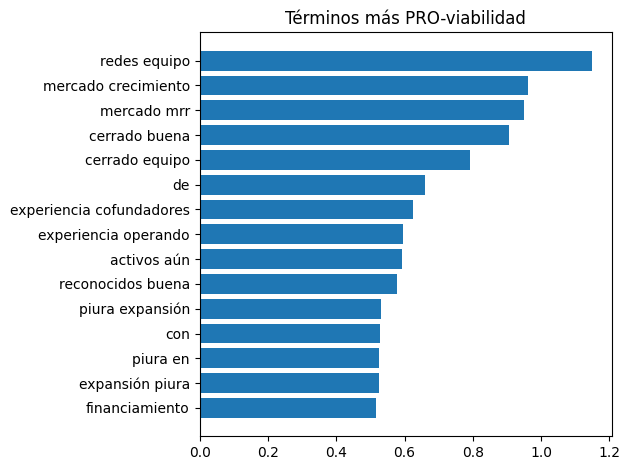

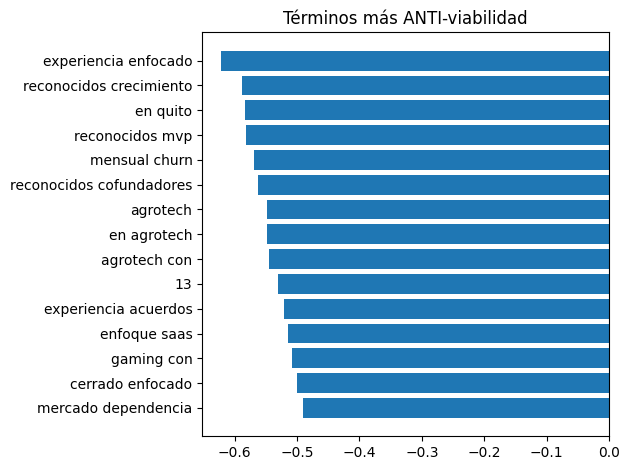

In [4]:

# Extrae términos top positivos/negativos
model = pipe.named_steps["clf"]
vec = pipe.named_steps["tfidf"]
terms = np.array(vec.get_feature_names_out())
coefs = model.coef_[0]
idx_pos = np.argsort(coefs)[-15:][::-1]
idx_neg = np.argsort(coefs)[:15]

plt.figure(); plt.barh(terms[idx_pos][::-1], coefs[idx_pos][::-1]); plt.title("Términos más PRO-viabilidad"); plt.tight_layout(); plt.show()
plt.figure(); plt.barh(terms[idx_neg][::-1], coefs[idx_neg][::-1]); plt.title("Términos más ANTI-viabilidad"); plt.tight_layout(); plt.show()


## Guardar modelo de texto y función de predicción

In [6]:

models_dir = Path("models"); models_dir.mkdir(parents=True, exist_ok=True)
dump(pipe, models_dir / "modelo_texto.joblib")
print("Modelo guardado en:", models_dir / "modelo_texto.joblib")

def predecir_texto(descripcion: str, thr=0.5):
    s = float(pipe.predict_proba([descripcion])[:,1])
    yhat = int(s>=thr)
    # explicación simple por términos clave
    import re
    tokens = np.array(vec.get_feature_names_out())
    # top 3 términos con mayor peso presentes en el texto
    term_weights = {t: w for t,w in zip(tokens, model.coef_[0]) if re.search(rf"\b{re.escape(t)}\b", descripcion.lower())}
    just = ", ".join(sorted(term_weights, key=term_weights.get, reverse=True)[:3]) or "(sin términos clave detectados)"
    return {"probabilidad": s, "viable": bool(yhat), "justificacion": f"Se detectaron señales en: {just}"}

ej = "MRR mensual 10k usd, clientes activos y acuerdos B2B; equipo con 6 años en logística."
predecir_texto(ej)


Modelo guardado en: models\modelo_texto.joblib


C:\Users\carlo\AppData\Local\Temp\ipykernel_23100\3889448298.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  s = float(pipe.predict_proba([descripcion])[:,1])


{'probabilidad': 0.43707936769837613,
 'viable': False,
 'justificacion': 'Se detectaron señales en: con, equipo con, años'}

## ✅ Confirmación

In [7]:
print('✅ Entrenamiento de modelo de texto completado y guardado correctamente.')

✅ Entrenamiento de modelo de texto completado y guardado correctamente.
